The Titanic dataset is one of the most famous datasets in machine learning. It has a wealth of features to analyze and an easily definable target - did the passenger survive or not? In this notebook, we'll take a look at how to preprocess the dataset, visualize the data to get clues about meaningful trends, and then implement and compare some classifiers on the data.

To start with, we'll import all the libraries we'll need.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BaseNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
warnings.filterwarnings("ignore")

After importing all our data libraries, we need to load in the dataset. Since we're using Pandas we can quickly check if the dataset has loaded in correctly just by printing the "head" of the dataset.

In [2]:
# load in the train and test data

training_data = pd.read_csv("train.csv")
testing_data = pd.read_csv("test.csv")

print(training_data.head(10))
print(testing_data.head(10))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54

An excellent first place to start when doing data analysis or machine learning is this - figure out what features are available for your use. Once again, Pandas makes this quit easy, we can just use the `keys` function on our dataframes.

Some featuers are numerical and some are non-numerical. It may also help to know which of our features are numerical and which aren't. Finally, another very useful feature we have access to is the "describe" feature, which gives us a quick breakdown of the important things about our dataset.

In [3]:
# let's see what features are availalbe to us
print(training_data.keys())
print(testing_data.keys())

# have to find out what our numerical features are
train_datatypes = training_data.dtypes
print(train_datatypes)
print(training_data.describe())

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000

One thing we definitely need to do is drop any null or NAN data. Why don't we make a function to see if there is any null data in our datasets?

In [4]:
def get_nulls(training, testing):
    print("Training Data:")
    print(pd.isnull(training).sum())
    print("Testing Data:")
    print(pd.isnull(testing).sum())

get_nulls(training_data, testing_data)

Training Data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Testing Data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


As it turns our, the "Cabin" column has quite a few missing values. We could try imputing/replacing these values, but let's just drop this column and get rid of it. The ticket numbers are just far too variable to be of any use when trying to predict survival rates, so let's drop that too. Note that we need to keep the shapes of the training and testing dataframes consistent, so if we drop columns from one dataset, we're going to need to do it to the other.

In [5]:
# let's drop the cabin column, because it has a lot of missing values
# ticket numbers contain far too many categories as well, so let's drop that too

training_data.drop(labels = ['Cabin', 'Ticket'], axis = 1, inplace=True)
testing_data.drop(labels = ['Cabin', 'Ticket'], axis = 1, inplace=True)

Now that we've loaded in the data and dropped any null values, we can start doing some visualization of the data. We don't want to plot over our actual training data in case we accidentally mess something up, so let's make a copy of the dataframe to plot. Now let's do a very simple plot and check the distribution of age groups.

We want to see if the data is uniformally distributed or if the data is skewed in some way. This is important to know for classification tasks like this, because we may need to impute some data and whether or not the data is skewed will affect what kind of imputation method we want to use. Replacing lost numbers with average values can throw off the classifier if there are large outliers or if the data is heavily skewed in one direction.

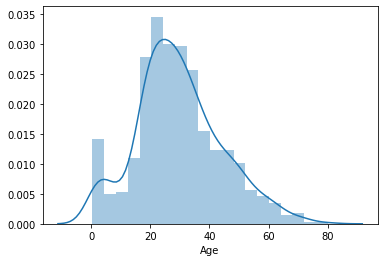

In [6]:
# let's plot the distribution
# we'll make a copy of the data so we don't accidentally alter anything
training_copy = training_data.copy()
training_copy.dropna(inplace = True)
sns.distplot(training_copy['Age'])
plt.show()

The data looks slightly skewed to the right, which means younger people are more prominent in the dataset. We're now going to fill in any missing values by using the median value instead of the average value, which should throw off our classifier less. Now we'll do another check for missing values, and this time there shouldn't be any.

In [7]:
# the data is slightly right skewed, or the young ages have slightly more prominence
# this means taking the mean/average value would be unduly affected by the skew
# hence we shouldn't use the mean to impute, rather we should use the median value,
# which will be less impacted by the skew

training_data["Age"].fillna(training_data["Age"].median(), inplace = True)
testing_data["Age"].fillna(testing_data["Age"].median(), inplace = True)
training_data["Embarked"].fillna("S", inplace = True)
testing_data["Fare"].fillna(testing_data["Fare"].median(), inplace = True)

get_nulls(training_data, testing_data)

# now there should be no more missing values
print(training_data.head(10))
print(testing_data.head(10))

Training Data:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
Testing Data:
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0     

We're now interested in getting potentially interesting trends, trends that could predict a passenger's survival. Let's try to visualize some possible correlations. 

We can do a bar plot of the survival rate compared with passenger sex to get an idea of how a passenger's sex impacted their survival chances. We can also get the total number of those who survived of both sexes by filtering by two criteria, we specify that the sex must be female/male and is must be found in the "Survived" column. Then we can just sum the numbers with the sum function. To print the percentage, all we have to do is add up the total and divide the number of people who survived per sex by the total.

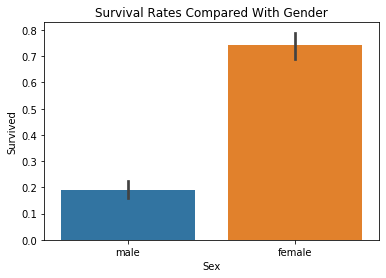

Total survivors:342
109
233
Percentage of women survived:68.12865497076024
Percentage of men survived:31.871345029239766


In [8]:
# now that the data has been prepped, let's do some visualization of the data
# let's examine some of the trends that exist between features

sns.barplot(x='Sex', y='Survived', data=training_data)
plt.title("Survival Rates Compared With Gender")
plt.show()

women_survived = training_data[training_data.Sex == "female"]["Survived"].sum()
men_survived = training_data[training_data.Sex == "male"]["Survived"].sum()

print("Total survivors:" + str(women_survived + men_survived))
print(men_survived)
print(women_survived)
print("Percentage of women survived:" + str(women_survived/(men_survived + women_survived) * 100))
print("Percentage of men survived:" + str(men_survived/(men_survived + women_survived) * 100))

It's not extremely surprising to see that women had a much higher survival rate then men. Women and children were instructed to get on the lifeboats first as the Titanic was sinking. Are there any other features that might have an interesting relationship with survival?

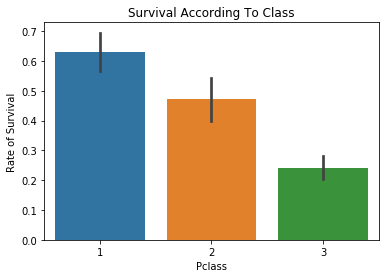

In [9]:
# let's see how the class of passengers affected survival rate

sns.barplot(x="Pclass", y="Survived", data=training_data)
plt.ylabel("Rate of Survival")
plt.title("Survival According To Class")
plt.show()

The Class that a passenger was in also had an effect on a passenger's chance of survival, it looks like. We can confirm this by getting the proportion of survivors for each class. It looks like Class 1 passengers were the largest section of survivors when separated by class.

In [10]:
# count the number of survivors in each class, and survivors total

class_1_survived = training_data[training_data.Pclass == 1]["Survived"].sum()
class_2_survived = training_data[training_data.Pclass == 2]["Survived"].sum()
class_3_survived = training_data[training_data.Pclass == 3]["Survived"].sum()
total_class_survived = class_1_survived + class_2_survived + class_3_survived

print("Prop. of Class 1 in survived:")
print(class_1_survived/total_class_survived)
print("Prop. of Class 2 in survived:")
print(class_2_survived/total_class_survived)
print("Prop. of Class 3 in survived:")
print(class_3_survived/total_class_survived)

Prop. of Class 1 in survived:
0.39766081871345027
Prop. of Class 2 in survived:
0.2543859649122807
Prop. of Class 3 in survived:
0.347953216374269


Now let's plot the class and survival rates, just like we did with sex and survival rates.

Text(0.5, 1.0, 'Survival rates based on Class and Gender')

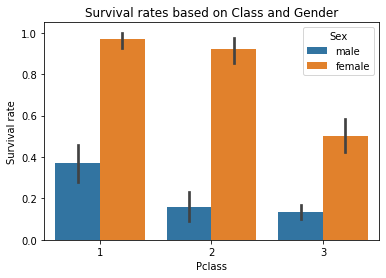

In [11]:
# plot both class and gender survival rates

sns.barplot(x="Pclass", y="Survived", hue="Sex", data=training_data)
plt.ylabel("Survival rate")
plt.title("Survival rates based on Class and Gender")

Another variable that seems to have a lot of influence on survial rate is age. Younger people may have been more likely to survive, and let's confirm this by plotting the ages of those who survived and the ages of those that perished. Notice that the distributions here roughly correlate with the distribution of the general age groups aboard the ship, with slight variations here and there, as would be expected.

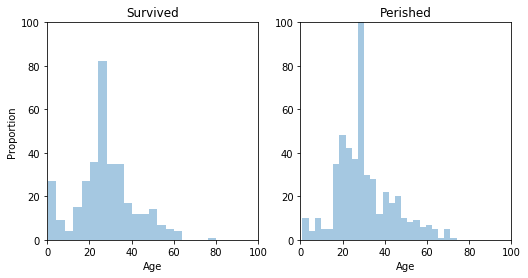

In [12]:
# age is a variable that has a lot of influence on survival rates
# start by selecting the people who have survived, along with their age

survived_ages = training_data[training_data.Survived == 1]["Age"]
perished_ages = training_data[training_data.Survived == 0]["Age"]

# time to create plots for these variables
# define the subplot

plt.subplot(1, 2, 1)
# plot the distribution
sns.distplot(survived_ages, kde=False)
# set the axis
plt.axis([0, 100, 0, 100])
plt.title("Survived")
plt.ylabel("Proportion")

plt.subplot(1, 2, 2)
# plot the distribution
sns.distplot(perished_ages, kde=False)
# set the axis
plt.axis([0, 100, 0, 100])
plt.title("Perished")

# adjust the subplots
plt.subplots_adjust(right=1.2)
plt.show()

There are alternate ways of visualizing these relationships. We can use a strip plot, or a violin plot.  The stip plot shows the number of individual occurences for both categories, spread out across the age groups. The violin plots show the relative occurence rate of an event per giveen feature. So the plot shown below has the perished and surived groups (centered at zero and one), for every class. The width of the violion shows the general occurence frequency. Finally, the pairplot shows the relationships between different features.

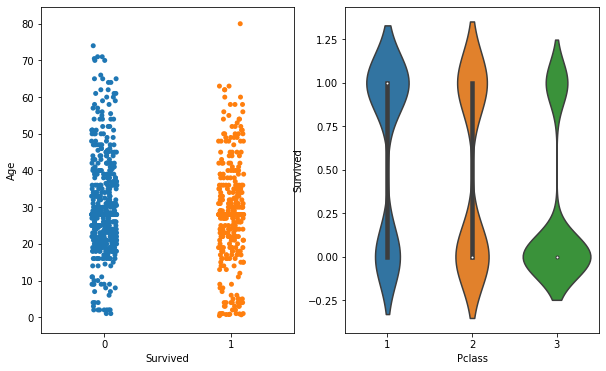

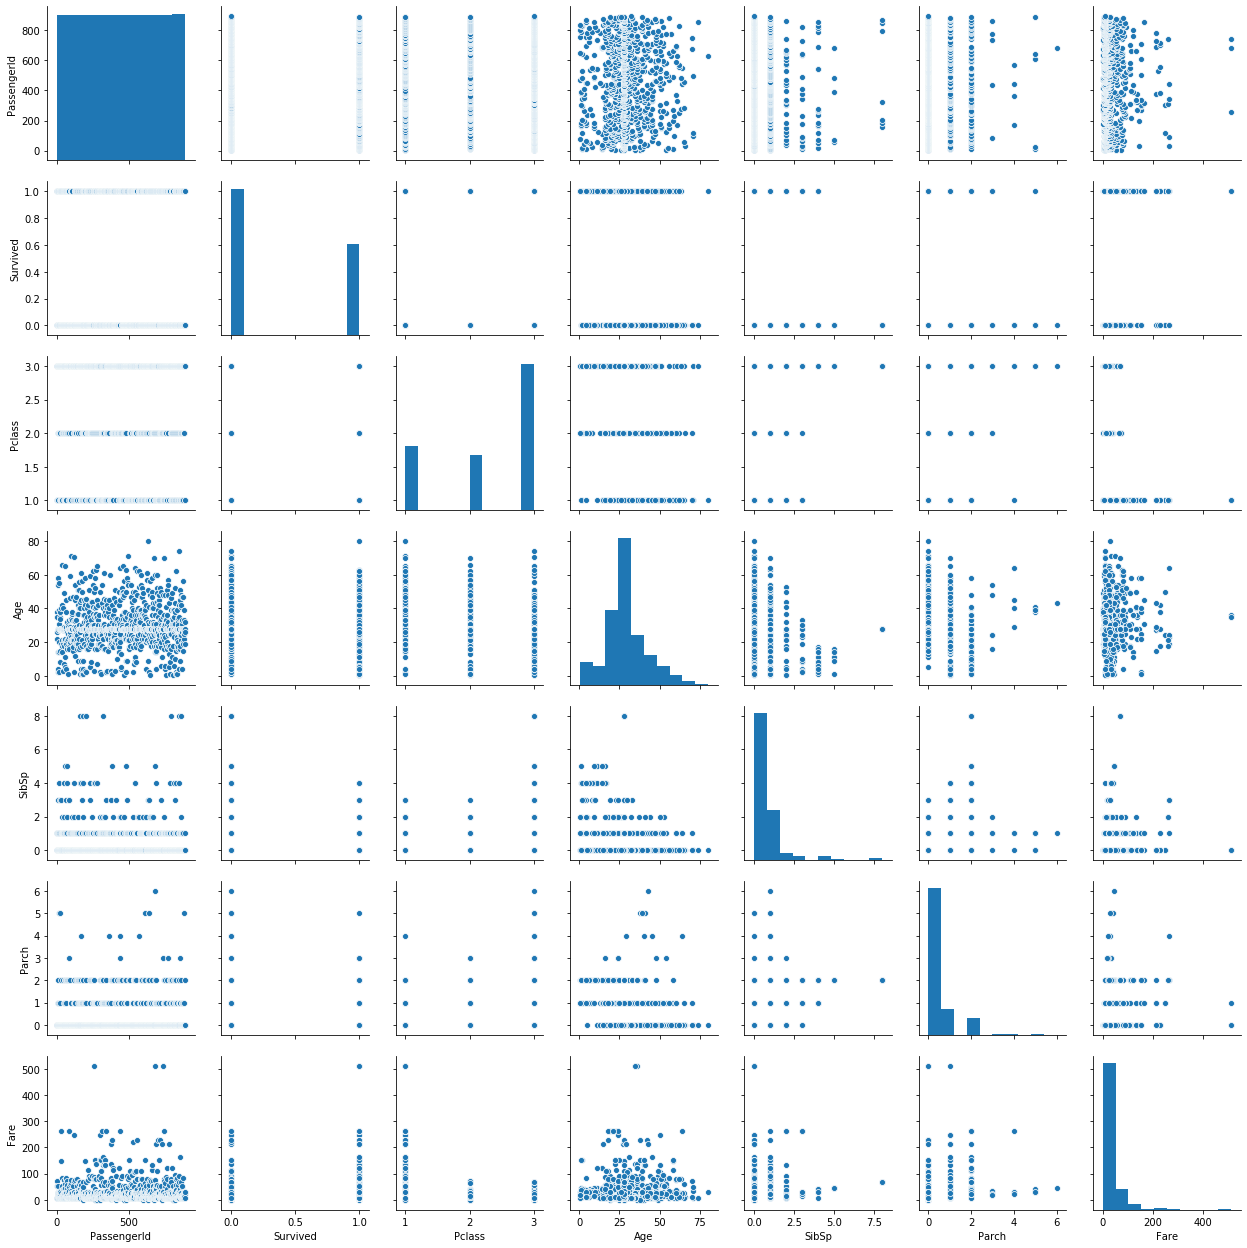

In [13]:
# we can also do a scatterplot of sorts

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                                figsize=(10, 6))

sns.stripplot(x="Survived", y="Age", data=training_data, jitter=True, ax=ax1)
sns.violinplot(x="Pclass", y="Survived", data=training_data, ax=ax2)
sns.pairplot(training_data)

plt.show()

Now let's do some feature engineering. In this case we're doing some preprocessing by transforming non-numerical values into numerical values. We can do this by encoding the data. The Label Encoder that is found in Scikit-learn is able to make numerical representations of non-numerical data, and we need to use it because our classifiers only work with numerical data.

In [14]:
# let's do some feature engineering
# sex and embarked status are non-numerical variables, we'll need to make them numerical values
# we can do this through one hot encoding

# let's check to see what some of the sex and embarked classes look like
print(training_data.sample(5))

encoder_1 = LabelEncoder()
# fir the encoder on the data
encoder_1.fit(training_data["Sex"])

#transform and replace the training data
training_sex_encoded = encoder_1.transform(training_data["Sex"])
training_data["Sex"] = training_sex_encoded
test_sex_encoded = encoder_1.transform(testing_data["Sex"])
testing_data["Sex"] = test_sex_encoded

encoder_2 = LabelEncoder()
encoder_2.fit(training_data["Embarked"])

training_embarked_encoded = encoder_2.transform(training_data["Embarked"])
training_data["Embarked"] = training_embarked_encoded
testing_embarked_encoded = encoder_2.transform(testing_data["Embarked"])
testing_data["Embarked"] = testing_embarked_encoded

# let's check to see if the transformation worked
print(training_data.sample(5))

     PassengerId  Survived  Pclass                         Name     Sex   Age  \
808          809         0       2            Meyer, Mr. August    male  39.0   
576          577         1       2         Garside, Miss. Ethel  female  34.0   
89            90         0       3       Celotti, Mr. Francesco    male  24.0   
116          117         0       3         Connors, Mr. Patrick    male  70.5   
277          278         0       2  Parkes, Mr. Francis "Frank"    male  28.0   

     SibSp  Parch   Fare Embarked  
808      0      0  13.00        S  
576      0      0  13.00        S  
89       0      0   8.05        S  
116      0      0   7.75        Q  
277      0      0   0.00        S  
     PassengerId  Survived  Pclass                                    Name  \
633          634         0       1           Parr, Mr. William Henry Marsh   
176          177         0       3           Lefebre, Master. Henry Forbes   
166          167         1       1  Chibnall, Mrs. (Edith Marth

There are some features that common sense tells us won't be very useful when trying to predict who survived and who didn't. We can probably drop the "name" column, under the assumption that it is going to be useless. (Some of the titles people had could have been indicative of social status, and therefore could play an influence in survival prediction. However, to keep the problem simpler, we'll drop this feature.)

In [15]:
# let's assume the name is going to be useless and drop it
training_data.drop("Name", axis = 1, inplace = True)
testing_data.drop("Name", axis = 1, inplace = True)

We're almost ready to start doing classification, but first we need to reshape certain features into arrays. We need to do this because we're going to rescale the features. Recscaling standardizes the representation of a dataset, taking outlying values and making them normal by recasting all the data in a similar range. This is important because large outliers can throw off our classifiers.

In [16]:
# remember that the scaler takes arrays, so any value we wish to reshape we need to turn into array to scale
ages_train = np.array(training_data["Age"]).reshape(-1, 1)
fares_train = np.array(training_data["Fare"]).reshape(-1, 1)
ages_test = np.array(testing_data["Age"]).reshape(-1, 1)
fares_test = np.array(testing_data["Fare"]).reshape(-1, 1)

Now that we've reshaped the data, we can scale it.

In [17]:
scaler = StandardScaler()

training_data["Age"] = scaler.fit_transform(ages_train)
training_data["Fare"] = scaler.fit_transform(fares_train)
testing_data["Age"] = scaler.fit_transform(ages_test)
testing_data["Fare"] = scaler.fit_transform(fares_test)

We're going to need to split up our data into features and labels. This is rather easy since our variables are so cleanly defined. We drop whether or not the passenger survived, along with the passenger ID. This makes sure there are no identifying variables in our features that could possibly bias the classifier. As you might guess, our target/label is the "Survived" column, so we make it the "y" values. Our testing data features (or more accurately "validation" features are going to be our testing data frame, minus the passenger ID. We aren't defining a y_test here, as that is what we're trying to predict. We'll split up part of the y_train to create labels for the validation set. 

In [18]:
# now to select our training and testing data
X_train = training_data.drop(labels=['PassengerId', 'Survived'], axis=1)
y_train = training_data['Survived']
X_test = testing_data.drop("PassengerId", axis=1)

print(X_train.head(5))

   Pclass  Sex       Age  SibSp  Parch      Fare  Embarked
0       3    1 -0.565736      1      0 -0.502445         2
1       1    0  0.663861      1      0  0.786845         0
2       3    0 -0.258337      0      0 -0.488854         2
3       1    0  0.433312      1      0  0.420730         2
4       3    1  0.433312      0      0 -0.486337         2


Now we can use the train_test_split function to create our features and targets for our training and validation data.

In [19]:
# do some training on the validation set
# make the train and test data from validation data

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=27)

We're going to be usign a number of different classifiers. We're also going to be looking for their best parameters/estimators with GridSearchCV. GridSearchCV takes a set of parameters/arguments we have decided upon and tests itself on the data using combinations of the parameters, returning the parameters that seem to give the best performance. We will then save these parameters in a new instance of the classifier, to hopefully get an optimized classifer. We'll do this for every classifier we choose. Here's the pattern for the first classifier.

In [20]:
svc_clf = SVC(probability=True)
svc_param = {"kernel": ["rbf", "linear"]}
grid_svc = GridSearchCV(svc_clf, svc_param)
grid_svc.fit(X_train, y_train)
svc_opt = grid_svc.best_estimator_

Now here's the pattern for the others.

In [21]:
linsvc_clf = LinearSVC()
linsvc_param = {"fit_intercept": [True, False] ,"max_iter": [100, 250, 500, 1000]}
linsvc_grid = GridSearchCV(linsvc_clf, linsvc_param)
linsvc_grid.fit(X_train, y_train)
lin_opt = linsvc_grid.best_estimator_

rf_clf = RandomForestClassifier()
parameters_rf = {"n_estimators": [4, 6, 8, 10, 12, 14, 16], "criterion": ["gini", "entropy"], "max_features": ["auto", "sqrt", "log2"],
                 "max_depth": [2, 3, 5, 10], "min_samples_split": [2, 3, 5, 10]}
grid_rf = GridSearchCV(rf_clf, parameters_rf)
grid_rf.fit(X_train, y_train)
rf_opt = grid_rf.best_estimator_

logreg_clf = LogisticRegression()
parameters_logreg = {"penalty": ["l2"], "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
                     "max_iter": [25, 50, 100, 200, 400]}
grid_logreg = GridSearchCV(logreg_clf, parameters_logreg)
grid_logreg.fit(X_train, y_train)
logreg_opt = grid_logreg.best_estimator_

knn_clf = KNeighborsClassifier()
parameters_knn = {"n_neighbors": [3, 5, 10, 15, 20], "weights": ["uniform", "distance"],
                  "leaf_size": [10, 20, 30, 45, 60]}
grid_knn = GridSearchCV(knn_clf, parameters_knn)
grid_knn.fit(X_train, y_train)
knn_opt = grid_knn.best_estimator_

bnb_clf = BernoulliNB()
bnb_params = {"alpha":[0.20, 0.50, 1.0]}
grd_bnb = GridSearchCV(bnb_clf, bnb_params)
grd_bnb.fit(X_train, y_train)
bnb_opt = grd_bnb.best_estimator_

gnb_clf = GaussianNB()
gnb_params = {}
grid_gnb = GridSearchCV(gnb_clf, gnb_params)
grid_gnb.fit(X_train, y_train)
gnb_opt = grid_gnb.best_estimator_

dt_clf = DecisionTreeClassifier()
parameters_dt = {"criterion": ["gini", "entropy"], "splitter": ["best", "random"], "max_features": ["auto", "log2", "sqrt"]}
grid_dt = GridSearchCV(dt_clf, parameters_dt)
grid_dt.fit(X_train, y_train)
dt_opt = grid_dt.best_estimator_

xg_clf = XGBClassifier()
parameters_xg = {"objective" : ["reg:linear"], "n_estimators" : [5, 10, 15, 20]}
grid_xg = GridSearchCV(xg_clf, parameters_xg)
grid_xg.fit(X_train, y_train)
xgb_opt = grid_xg.best_estimator_

mlp_clf = MLPClassifier()
parameters_mlp = {"solver": ["adam", "sgd"], "max_iter": [100, 200, 300],
                  "hidden_layer_sizes": [50, 100, 200], "activation": ["relu", "tanh"]}
grid_mlp = GridSearchCV(mlp_clf, parameters_mlp)
grid_mlp.fit(X_train, y_train)
mlp_opt = grid_mlp.best_estimator_

[06:40:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:40:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:40:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:40:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:40:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:40:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:40:56] WARNI

We'll create a list of the classifiers and use a for loop to carry out the training and check their performance.

In [22]:
classifiers = [svc_opt, lin_opt, rf_opt, logreg_opt, knn_opt, bnb_opt, gnb_opt, dt_opt, xgb_opt, mlp_opt]

metrics = ["Classifier", "Accuracy", "Log Loss", "F1"]
# create a dataframe to store the variables
log = pd.DataFrame(columns=metrics)

for clf in classifiers:
    clf.fit(X_train, y_train)
    classifier = clf.__class__.__name__

    print(classifier + " perfofrmance is:")
    
    preds = clf.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print("Accuracy: {}".format(acc))
    
    preds = clf.predict(X_val)
    l_loss = log_loss(y_val, preds)
    print("Log Loss: {}".format(l_loss))
    
    preds = clf.predict(X_val)
    f1 = f1_score(y_val, preds)
    print("F1 Score: {}".format(f1))
    
    print("Next classifier...")
    print()
    
    logs = pd.DataFrame([[classifier, acc*100, l_loss, f1]], columns=metrics)
    log = log.append(logs)

SVC perfofrmance is:
Accuracy: 0.8777777777777778
Log Loss: 4.221441541485982
F1 Score: 0.8358208955223881
Next classifier...

LinearSVC perfofrmance is:
Accuracy: 0.8555555555555555
Log Loss: 4.9889787902332206
F1 Score: 0.8059701492537314
Next classifier...

RandomForestClassifier perfofrmance is:
Accuracy: 0.8333333333333334
Log Loss: 5.75650715456457
F1 Score: 0.7692307692307692
Next classifier...

LogisticRegression perfofrmance is:
Accuracy: 0.8555555555555555
Log Loss: 4.9889787902332206
F1 Score: 0.8059701492537314
Next classifier...

KNeighborsClassifier perfofrmance is:
Accuracy: 0.8222222222222222
Log Loss: 6.140262452314354
F1 Score: 0.7419354838709677
Next classifier...

BernoulliNB perfofrmance is:
Accuracy: 0.7555555555555555
Log Loss: 8.442945273883199
F1 Score: 0.7179487179487181
Next classifier...

GaussianNB perfofrmance is:
Accuracy: 0.8555555555555555
Log Loss: 4.9889876746491115
F1 Score: 0.8115942028985507
Next classifier...

DecisionTreeClassifier perfofrmance i

The results from all the different classifiers are in. Let's visualize them to make comparison easier and more intuitive.

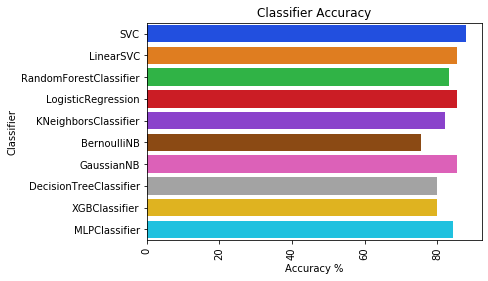

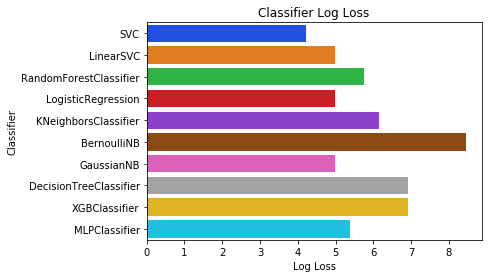

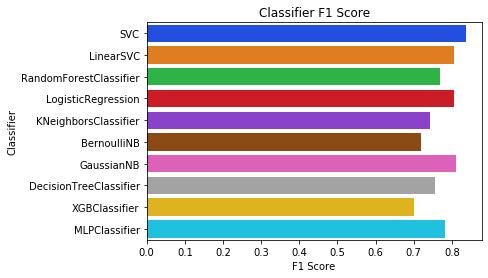

In [23]:
sns.barplot(x='Accuracy', y='Classifier', data=log, palette="bright")
plt.xticks(rotation=90)
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.barplot(x='Log Loss', y='Classifier', data=log, palette="bright")
plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

sns.barplot(x='F1', y='Classifier', data=log, palette="bright")
plt.xlabel('F1 Score')
plt.title('Classifier F1 Score')
plt.show()

We're going to do one last thing. We're going to create a voting/ensemble classifier that takes multiple classifiers and returns the average of their vote. We'll take the five highest scoring classifiers for this. We want an odd number so that there won't be a tie. According to the F1 score, which is likely the most reliable metric, the best classifiers were: Regular SVC, the Multi-layer Perceptron (a simple neural net), Logistic Regression, the K Neighbots Classifier, and Linear SVC.

In [24]:
voting_clf = VotingClassifier(estimators=[('SVC', svc_opt), ('GNB', gnb_opt), ('LogReg', logreg_opt), ('RF', rf_opt), ('MLP', mlp_opt)], voting='soft')
voting_clf.fit(X_train, y_train)
preds = voting_clf.predict(X_val)
acc = accuracy_score(y_val, preds)
l_loss = log_loss(y_val, preds)
f1 = f1_score(y_val, preds)

print("Accuracy is: " + str(acc))
print("Log Loss is: " + str(l_loss))
print("F1 Score is: " + str(f1))

Accuracy is: 0.8777777777777778
Log Loss is: 4.221441541485982
F1 Score is: 0.8358208955223881


The voting classifier may not be of tremendous use on such a small dataset, but it is a good tactic to know about. In this case it always seem to perform at least as well as the average classifier in the list of classifiers and will usually perform better. Another benefit of ensemble methods is that they are often more robust to overfitting. Keep in mind as you run these cells that there is a possibility for variance in the classifier performance.